<a href="https://colab.research.google.com/github/WalterPHD/Ai-Data/blob/main/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 1

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
df = pd.read_csv(os.path.join(csv_path, 'jena_climate_2009_2016.csv'))

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In [6]:
TRAIN_SPLIT = 300000

In [7]:
tf.random.set_seed(13)


In [8]:

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<Axes: xlabel='Date Time'>], dtype=object)

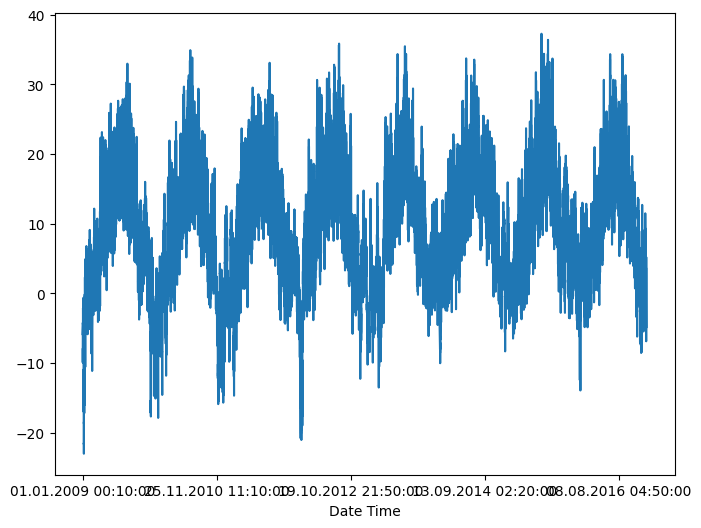

In [9]:
uni_data.plot(subplots=True)

Problem 2

In [10]:
uni_data = uni_data.values


In [11]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [12]:

uni_data = (uni_data-uni_train_mean)/uni_train_std

In [13]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,univariate_past_history,univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,univariate_past_history,univariate_future_target)

In [14]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [15]:

def create_time_steps(length):
  return list(range(-length, 0))

In [16]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

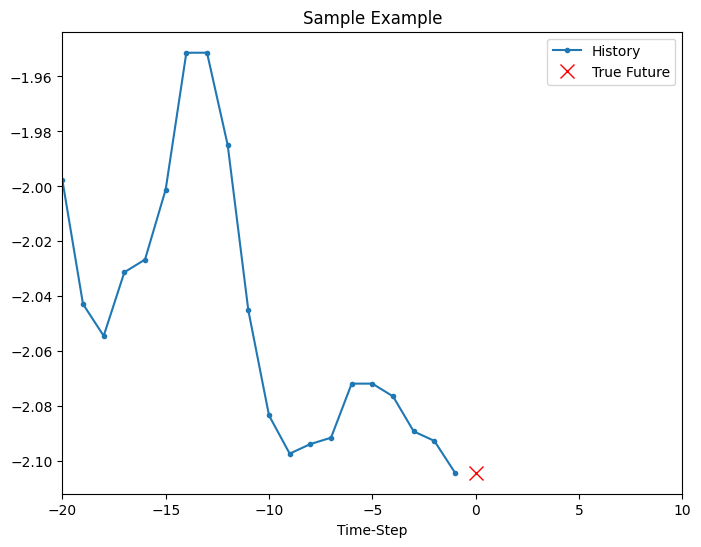

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [18]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

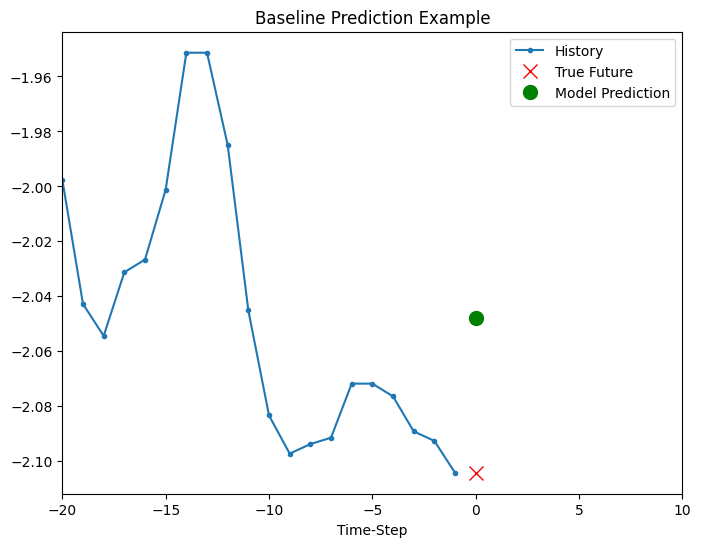

In [19]:

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')


In [20]:

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
(256, 1)


In [23]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5005 - val_loss: 0.0613
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0981 - val_loss: 0.0300
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0457 - val_loss: 0.0263
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0476 - val_loss: 0.0229
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0241 - val_loss: 0.0210
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0259 - val_loss: 0.0203
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0285 - val_loss: 0.0188
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0259 - val_loss: 0.0180
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0239 - val_loss: 0.0171
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0225 - val_loss: 0.0164


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


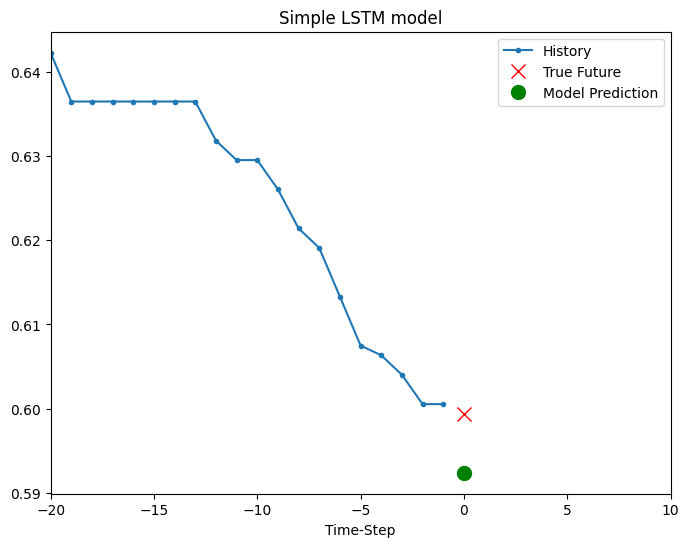

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


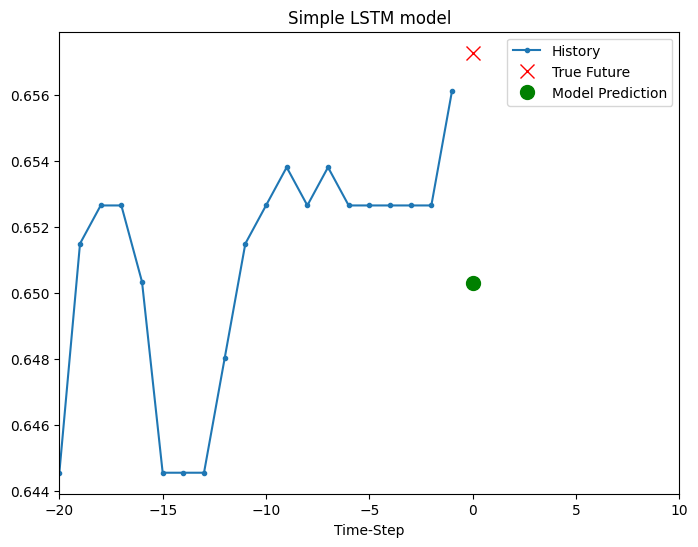

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


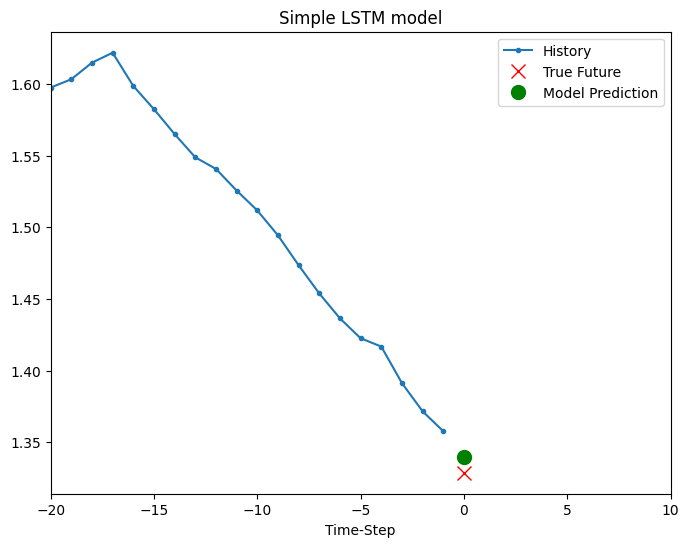

In [24]:

for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [25]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [26]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

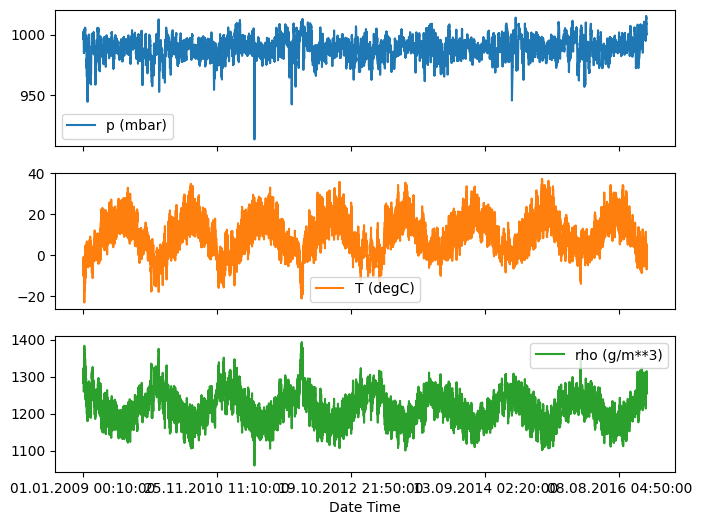

In [27]:

features.plot(subplots=True)


In [28]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)


In [29]:
dataset = (dataset-data_mean)/data_std

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [31]:

past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,TRAIN_SPLIT, past_history,future_target, STEP,single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],TRAIN_SPLIT, None, past_history,future_target, STEP,single_step=True)

In [32]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [33]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


In [34]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(256, 1)


In [36]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_single,validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.3327 - val_loss: 0.2548
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.2685 - val_loss: 0.2351
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.2654 - val_loss: 0.2450
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - loss: 0.2642 - val_loss: 0.2364
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.2202 - val_loss: 0.2334
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 0.2432 - val_loss: 0.2534
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.2439 - val_loss: 0.2574
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 0.2388 - val_loss: 0.2525
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - loss: 0.2490 - val_loss: 0.2459
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - loss: 0.2549 - val_loss: 0.2339


In [37]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

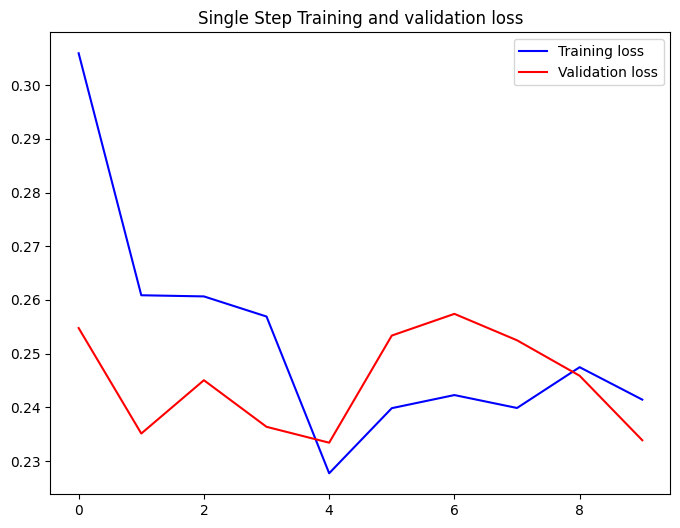

In [38]:

plot_train_history(single_step_history,'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


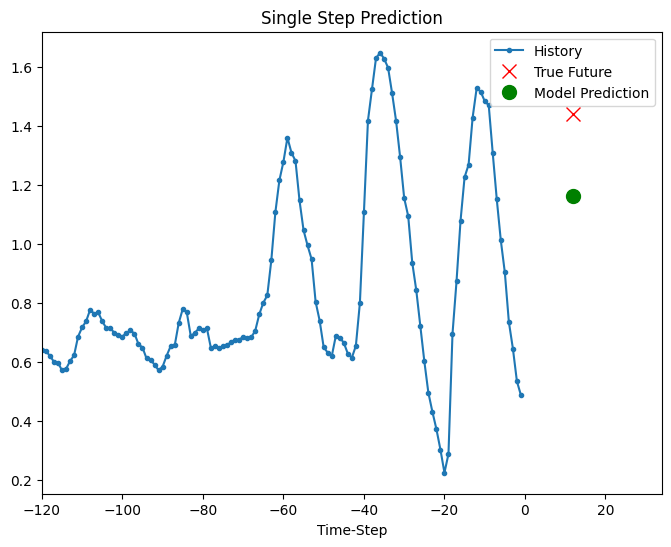

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


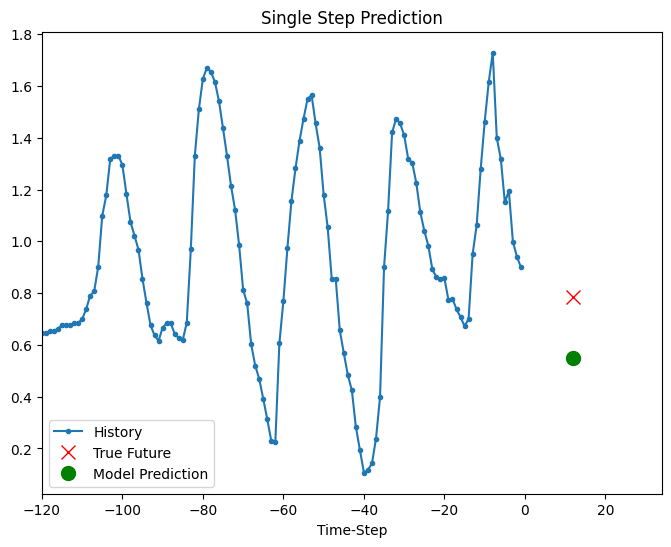

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


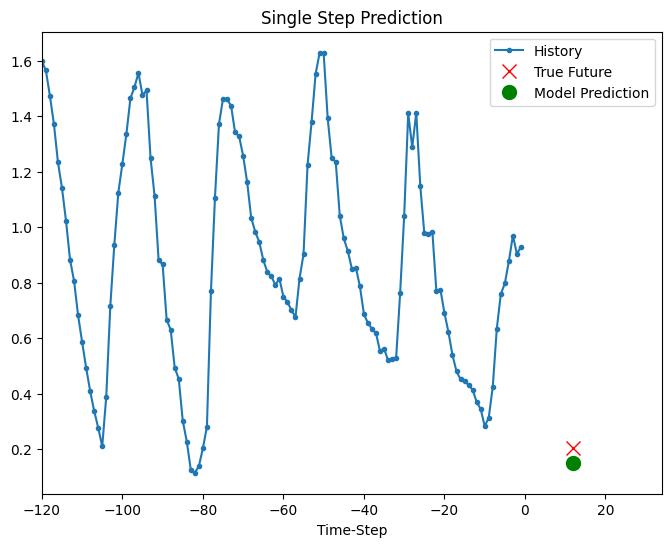

In [39]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),single_step_model.predict(x)[0]], 12,'Single Step Prediction')
  plot.show()

In [40]:

future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,TRAIN_SPLIT, past_history,future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],TRAIN_SPLIT, None, past_history,future_target, STEP)

In [41]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [42]:

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [43]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


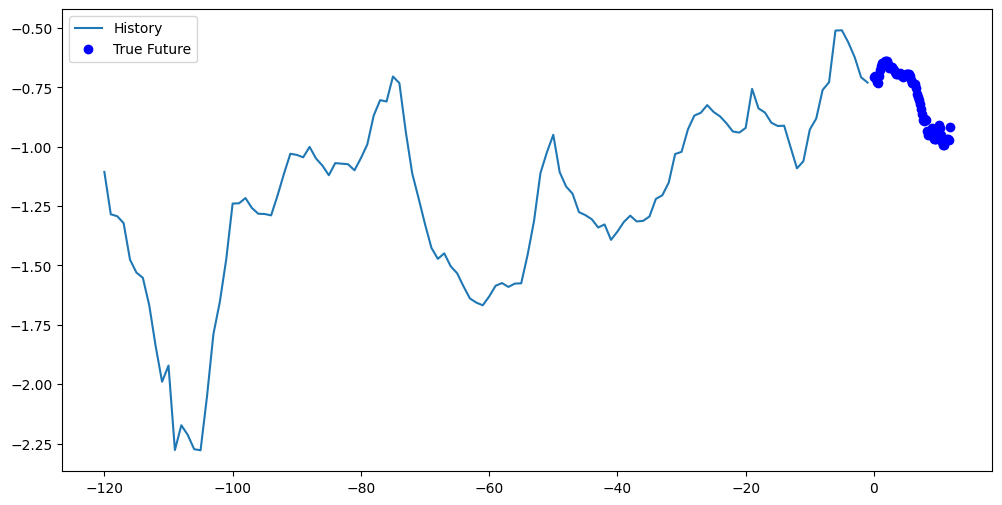

In [44]:

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [45]:

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,return_sequences=True,input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [46]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
(256, 72)


In [47]:

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi,validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - loss: 0.7421 - val_loss: 0.2923
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step - loss: 0.3350 - val_loss: 0.2763
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.3293 - val_loss: 0.2517
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 206ms/step - loss: 0.2574 - val_loss: 0.2218
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 208ms/step - loss: 0.1982 - val_loss: 0.2008
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - loss: 0.2106 - val_loss: 0.2165
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.2088 - val_loss: 0.2060
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.2020 - val_loss: 0.1961
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step - loss: 0.2088 - val_loss: 0.1911
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - loss: 0.2027 - val_loss: 0.1885


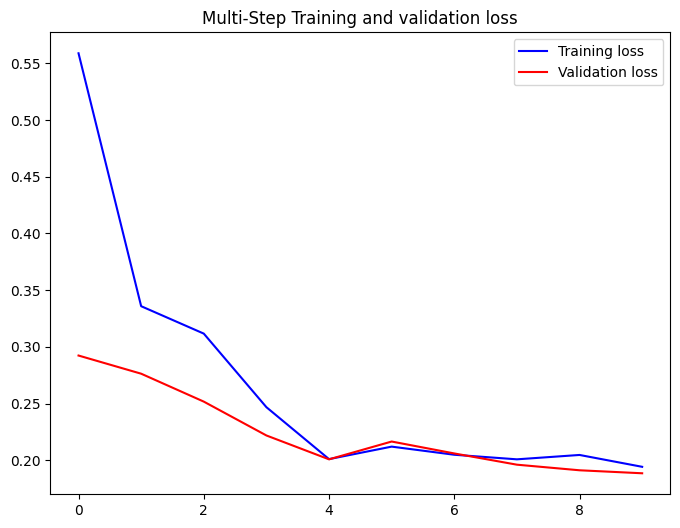

In [48]:

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


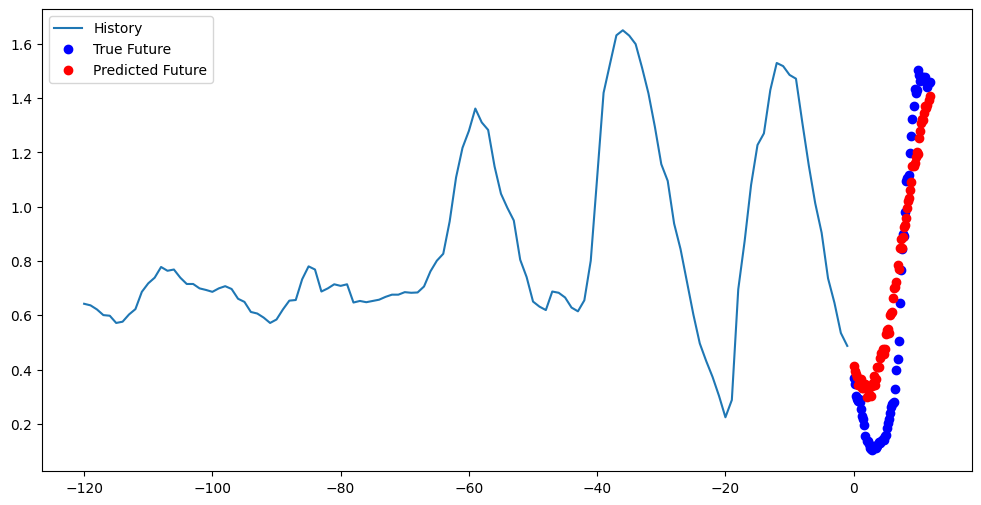

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


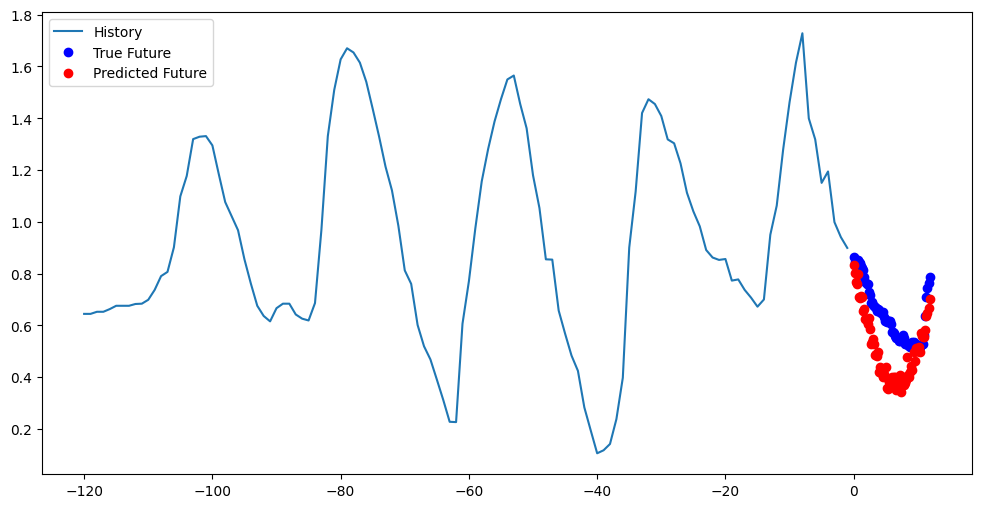

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


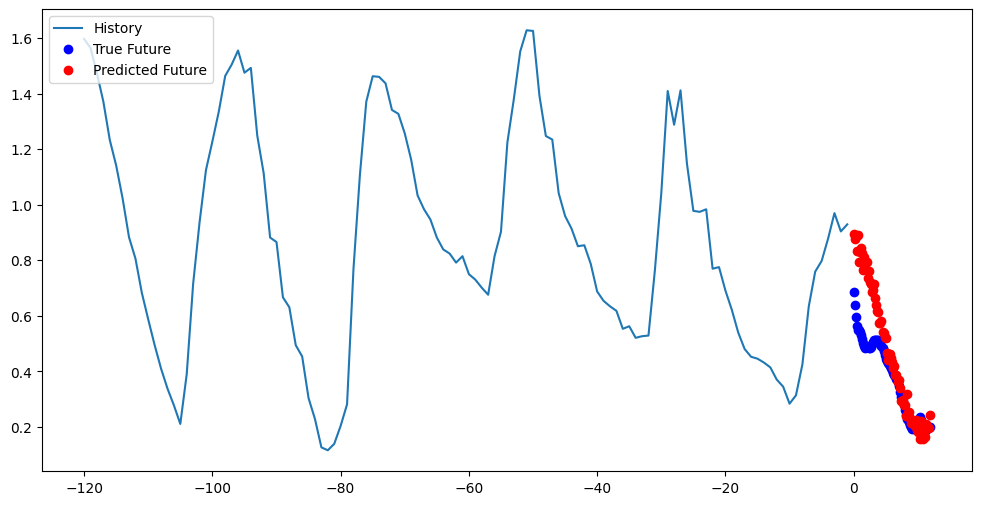

In [49]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Problem 3

In [50]:
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.optimizers import Adam # - Works

df = pd.read_csv("Iris.csv")

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [51]:
K.clear_session( )

In [52]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,451 (21.29 KB)

 Trainable params: 5,451 (21.29 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
history = model.fit(X_train, y_train,batch_size=10,epochs=10,verbose=1,callbacks=[callback],validation_data=(X_val, y_val))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4703 - loss: 1.1779 - val_accuracy: 0.9375 - val_loss: 0.4800
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7228 - loss: 0.5377 - val_accuracy: 0.8125 - val_loss: 0.4357
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8997 - loss: 0.3365 - val_accuracy: 0.8750 - val_loss: 0.2970
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8165 - loss: 0.3597 - val_accuracy: 1.0000 - val_loss: 0.2143
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9101 - loss: 0.2368 - val_accuracy: 1.0000 - val_loss: 0.1707
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9437 - loss: 0.1727 - val_accuracy: 0.9375 - val_loss: 0.1432
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9292 - loss: 0.1888 - val_accuracy: 1.0000 - val_loss: 0.1163
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9660 - loss: 0.1674 - val_accuracy: 1.0000 - val_loss: 0.0872


In [55]:

y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
y_pred_proba [1.0156038e-02 9.9736726e-01 5.9479158e-03 9.9916971e-01 9.0245271e-01
 9.9827516e-01 1.5621617e-01 7.6027834e-01 9.9915504e-01 9.5669669e-01
 9.9224329e-01 9.9475628e-01 9.9865144e-01 6.4249508e-02 1.0176973e-03
 3.8106276e-03 5.5808097e-01 7.2680024e-04 9.2693961e-01 2.2153787e-03]
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]
y_test [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [56]:

score = model.evaluate(X_test, y_test, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.20673641562461853
Train accuracy: 0.8999999761581421


Problem 4

In [58]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("Iris.csv")

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int64)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

In [59]:

K.clear_session( )
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,653 (22.08 KB)

 Trainable params: 5,653 (22.08 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

history = model.fit(X_train, y_train_one_hot, batch_size=10, epochs=10, verbose=0, validation_data=(X_val, y_val_one_hot))

In [62]:
y_pred_proba = model.predict(X_test)[:, 0]
y_pred = np.where(y_pred_proba >0.5, 1, 0)

print("y_pred_proba", y_pred_proba)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
y_pred_proba [2.52236482e-10 1.68420083e-03 9.99049962e-01 3.79163728e-10
 9.96068060e-01 5.86786869e-12 9.97081816e-01 2.61635083e-04
 1.41071054e-04 2.58246646e-03 1.18298855e-08 5.29953511e-04
 1.54398163e-04 1.42720863e-04 6.19622588e-05 9.94621396e-01
 8.92857279e-05 1.08843888e-04 9.93030369e-01 9.98412073e-01
 5.31400213e-09 2.97450224e-05 9.91286635e-01 9.91053045e-01
 1.03222033e-06 9.98117328e-01 9.93961632e-01 1.02918025e-03
 1.16634546e-02 9.94179010e-01]
y_pred [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [63]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred)
print('y_test', y_test.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
y_pred [2 1 0 2 0 2 0 1 1 1 2 1 1 1 2 0 2 2 0 0 2 2 0 0 2 0 0 1 1 0]
y_test [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0]


In [64]:

score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.20099906623363495
Train accuracy: 0.8666666746139526


Problem 5

In [66]:
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('train.csv')

x = train[['GrLivArea', 'YearBuilt']]
y = train[['SalePrice']]

x = np.log(x).values
y = np.log(y).values

sc = StandardScaler()
sc.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [67]:
K.clear_session( )


In [68]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1, activation = tf.keras.activations.linear))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [69]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,351 (20.90 KB)

 Trainable params: 5,351 (20.90 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.01), metrics=['mse'])
history = model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, callbacks=[callback], validation_data=(X_val, y_val))


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.4367 - mse: 1.4367 - val_loss: 0.0932 - val_mse: 0.0932
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0881 - mse: 0.0881 - val_loss: 0.0701 - val_mse: 0.0701
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1125 - mse: 0.1125 - val_loss: 0.1149 - val_mse: 0.1149
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1003 - mse: 0.1003 - val_loss: 0.1035 - val_mse: 0.1035
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1044 - mse: 0.1044 - val_loss: 0.0700 - val_mse: 0.0700
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.0796 - val_mse: 0.0796
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0995 - mse: 0.0995 - val_loss: 0.0879 - val_mse: 0.0879


In [74]:
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba
print("y_pred", y_pred.ravel()[:5])
print('y_test', y_test.ravel()[:5])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
y_pred [12.599103 12.204848 11.985911 12.424925 11.914688]
y_test [12.20918779 11.79810441 11.60823564 12.16525065 11.38509209]


In [75]:
score = model.evaluate(X_test, y_test, verbose=0)
print('loss (test):', score[0])
print('Mean Squared Error (test):', score[1])

loss (test): 0.07934021949768066
Mean Squared Error (test): 0.07934021949768066


Problem 6

In [77]:

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
X_train /= 255
X_test /= 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [78]:
K.clear_session( )

In [79]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation = tf.nn.relu, input_shape=(784,)))
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,360 (177.19 KB)

 Trainable params: 45,360 (177.19 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.005), metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot, batch_size=20, epochs=5, verbose=1, validation_data=(X_val, y_val_one_hot))

Epoch 1/5
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8718 - loss: 0.4180 - val_accuracy: 0.9428 - val_loss: 0.1959
Epoch 2/5
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9411 - loss: 0.2012 - val_accuracy: 0.9397 - val_loss: 0.2058
Epoch 3/5
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9521 - loss: 0.1650 - val_accuracy: 0.9280 - val_loss: 0.2621
Epoch 4/5
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9581 - loss: 0.1491 - val_accuracy: 0.9379 - val_loss: 0.2252
Epoch 5/5
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9605 - loss: 0.1382 - val_accuracy: 0.9208 - val_loss: 0.3260


In [82]:

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred", y_pred[:10])
print('y_test', y_test.ravel()[:10])


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
y_pred [7 2 1 0 9 1 4 9 6 9]
y_test [7 2 1 0 4 1 4 9 5 9]


In [83]:
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3048872947692871
Test accuracy: 0.9244999885559082


Problem 7

In [84]:
#import data
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [85]:

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 338kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.6MB/s]


In [86]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [87]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [88]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [89]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [90]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [91]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298329  [    0/60000]
loss: 2.291524  [ 6400/60000]
loss: 2.271418  [12800/60000]
loss: 2.273270  [19200/60000]
loss: 2.250006  [25600/60000]
loss: 2.226314  [32000/60000]
loss: 2.223435  [38400/60000]
loss: 2.194756  [44800/60000]
loss: 2.185455  [51200/60000]
loss: 2.158042  [57600/60000]
Test Error: 
 Accuracy: 57.8%, Avg loss: 2.149107 

Epoch 2
-------------------------------
loss: 2.157335  [    0/60000]
loss: 2.144693  [ 6400/60000]
loss: 2.085844  [12800/60000]
loss: 2.105514  [19200/60000]
loss: 2.044489  [25600/60000]
loss: 1.993720  [32000/60000]
loss: 2.005466  [38400/60000]
loss: 1.936164  [44800/60000]
loss: 1.942286  [51200/60000]
loss: 1.855915  [57600/60000]
Test Error: 
 Accuracy: 59.7%, Avg loss: 1.861830 

Epoch 3
-------------------------------
loss: 1.904413  [    0/60000]
loss: 1.863435  [ 6400/60000]
loss: 1.746679  [12800/60000]
loss: 1.788146  [19200/60000]
loss: 1.666984  [25600/60000]
loss: 1.636344  [32000/600

In [92]:

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [93]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [94]:

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Problem 8

TensorFlow is a very powerful and mature deep learning library with strong visualisation capabilities and several options to use for high-level model development. It has production-ready deployment options and supports mobile platforms. TensorFlow is a good option if you :

Develop models for production use.
Develop models that are to be deployed on mobile platforms
Want good community support and comprehensive documentation
Want rich learning resources in a variety of formats (TensorFlow has a comprehensive MOOC)
Want or need to use Tensorboard
Need to use large-scale distributed model building
PyTorch is a fully featured framework for building deep learning models, which is a type of machine learning that’s commonly used in applications like image recognition and language processing. Written in Python, it’s relatively easy for most machine learning developers to learn and use. PyTorch is distinctive for its excellent support for GPUs and its use of reverse-mode auto-differentiation, which enables computation graphs to be modified on the fly. This makes it a popular choice for fast experimentation and prototyping.

Why PyTorch?

PyTorch is the work of developers at Facebook AI Research and several other labs. The framework combines the efficient and flexible GPU-accelerated backend libraries from Torch with an intuitive Python frontend that focuses on rapid prototyping, readable code, and support for the widest possible variety of deep learning models. Pytorch lets developers use the familiar imperative programming approach, but still output to graphs. It was released to open source in 2017, and its Python roots have made it a favorite with machine learning developers.

PyTorch is still a young framework that is growing rapidly. It may be suitable for you if you:

You are doing research or the non-functional requirements of your production are not very high
You want a better development and debugging experience
You like all things Python